In [ ]:
import cv2
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import joblib
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from numpy.linalg import norm
plt.rcParams["image.cmap"] = "gray"


# Loading and Preprocessing Images

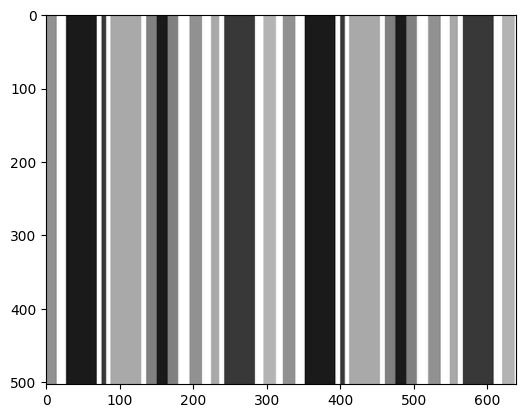

In [2]:

data = glob(r"C:\\Users\\Hozien\\Desktop\\UST-CSAI\\Year 3 Semester 2\\DSAI 352 Computer Vision\\Assignments\\A 4\\images\*\*.jpg")

len(data), type(data)
data1 = []
for i in range(3600):
    data1.append(cv.imread(data[i], 1))

plt.imshow(data1[0][:, :, ::-1])
images = []

for n in range(0, len(data1)):
    images.append(np.array(data1[n]))
bw_images = []

for img in images:
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        bw_images.append(img)

plt.imshow(bw_images[1])
plt.show()

# Extracting SIFT Features

In [4]:
extractor = cv.SIFT_create()

keypoints = []
descriptors = []
for img in bw_images:
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

print(len(descriptors))

3600


In [5]:
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    if img_descriptors is None:
        to_drop.append(i)

print(to_drop)
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(len(descriptors))

[0, 1, 3, 5, 6, 8, 9, 10, 16, 18, 20, 25, 28, 29, 35, 41, 43, 44, 45, 50, 51, 52, 53, 63, 64, 66, 67, 70, 88, 103, 115, 144, 149, 182, 602, 966, 975, 980, 994, 995, 1037, 1859, 1900, 1934, 1979, 2068, 2085, 2086, 2087, 2088, 2152, 2173, 2261, 2644, 2657, 2662, 2667, 2671, 2681, 2683, 2706, 2714, 2716, 2717, 2719, 2722, 3511, 3520, 3521, 3534]
3530


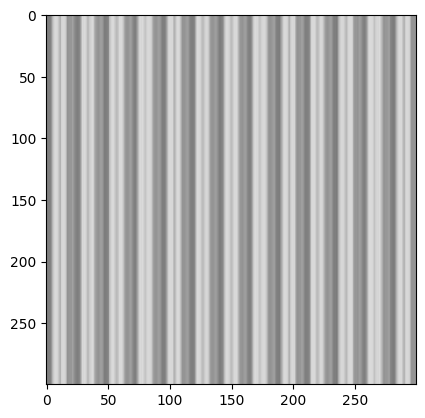

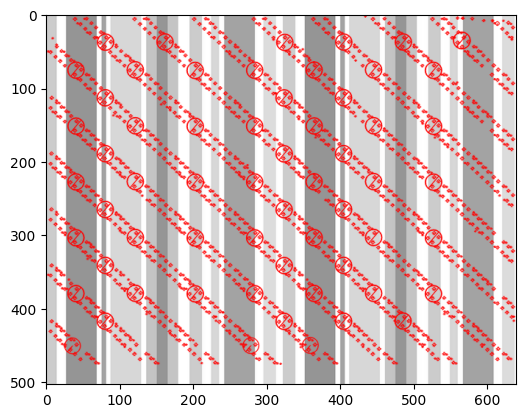

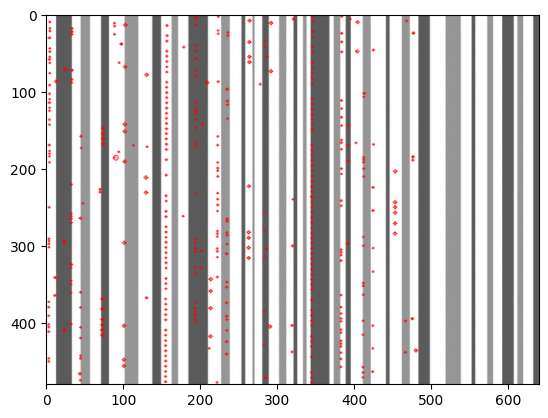

In [6]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x])
    plt.show()
sample_idx = np.random.randint(0, len(descriptors), 500).tolist()
len(sample_idx)
descriptors_sample = []
for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [8]:
# Find the maximum length of the descriptors
max_length = max(descriptor.shape[0] for descriptor in descriptors_sample)

# Pad the descriptors to have the same length
padded_descriptors_sample = [np.pad(descriptor, ((
    0, max_length - descriptor.shape[0]), (0, 0)), mode='constant') for descriptor in descriptors_sample]

# Convert to numpy array
np.array(padded_descriptors_sample).shape

MemoryError: Unable to allocate 16.4 MiB for an array with shape (33568, 128) and data type float32

In [9]:
all_descriptors = []
for img_descriptors in descriptors_sample:
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
all_descriptors = np.stack(all_descriptors)
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
print(count[:5])
print(sum(count))

[2877, 2218, 585, 348, 1673]
1166542


# Vary the number of images used for clustering

Results for sample size = 500


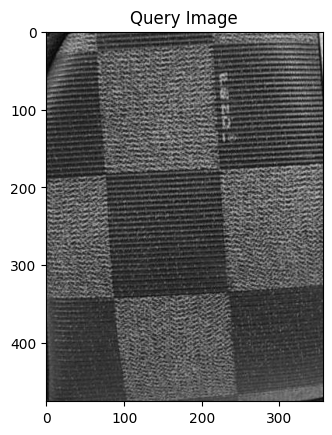

Cosine Similarity: 1.0000


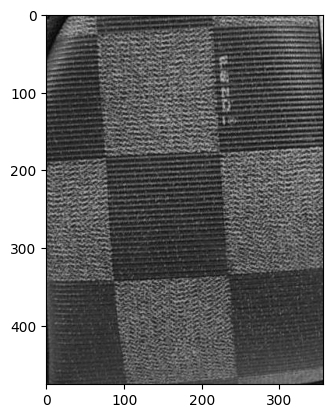

Cosine Similarity: 0.8994


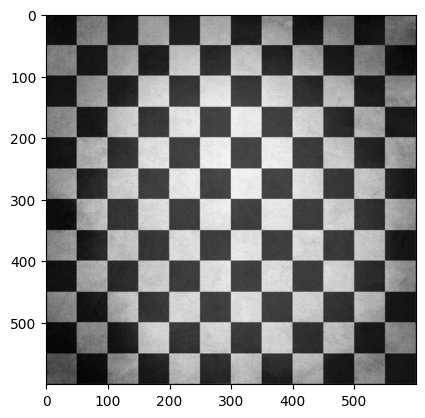

Cosine Similarity: 0.8963


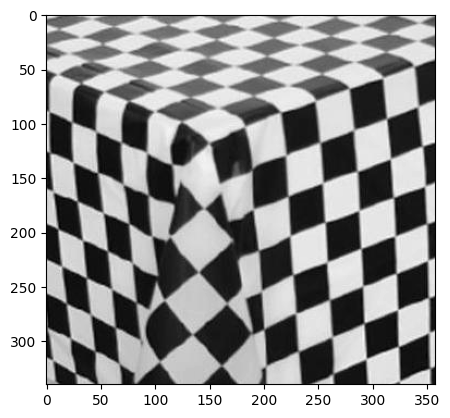

Cosine Similarity: 0.8611


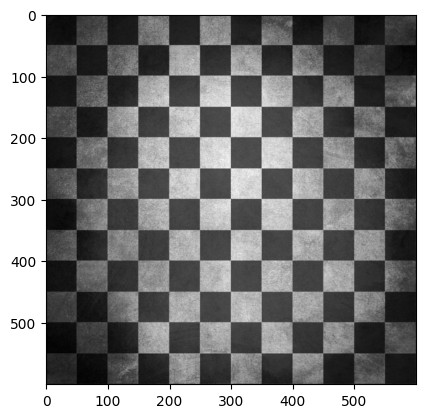

Cosine Similarity: 0.8560


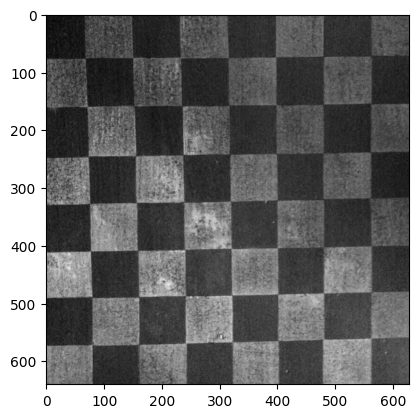

Results for sample size = 1000


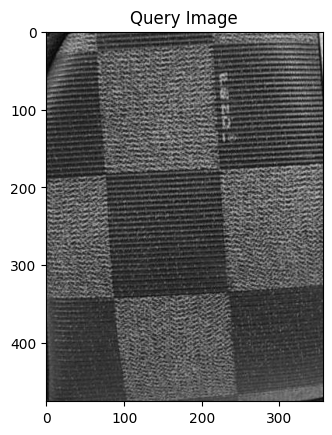

Cosine Similarity: 1.0000


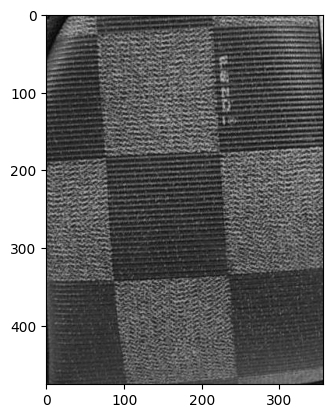

Cosine Similarity: 0.8716


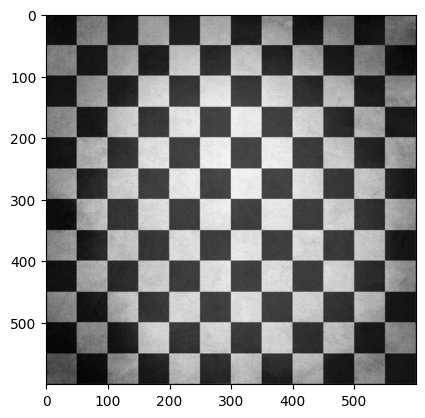

Cosine Similarity: 0.8657


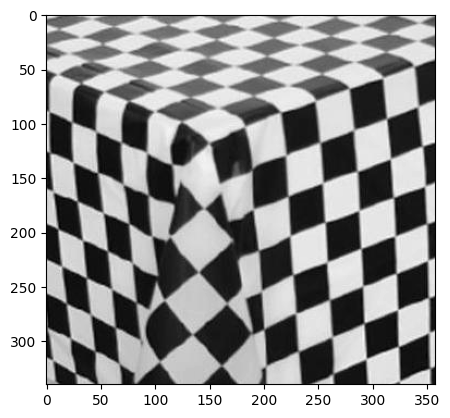

Cosine Similarity: 0.8432


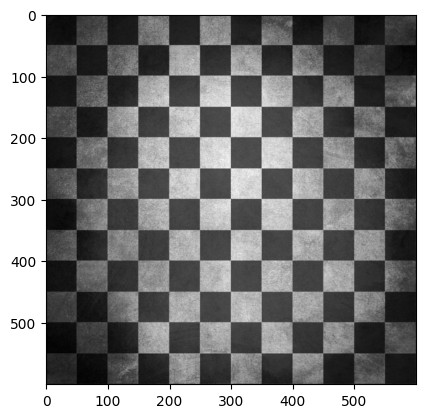

Cosine Similarity: 0.8406


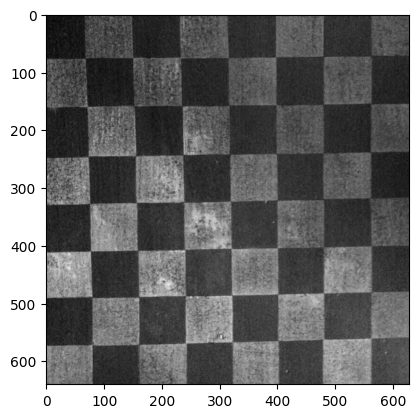

Results for sample size = 1500


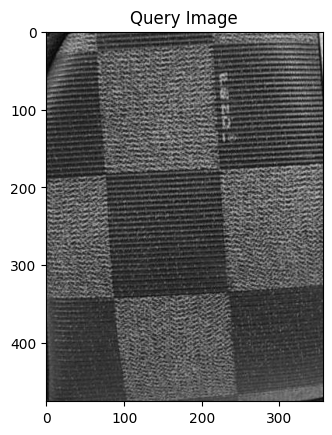

Cosine Similarity: 1.0000


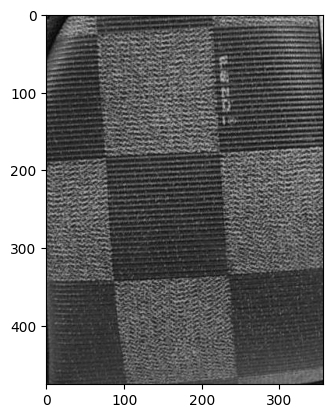

Cosine Similarity: 0.9013


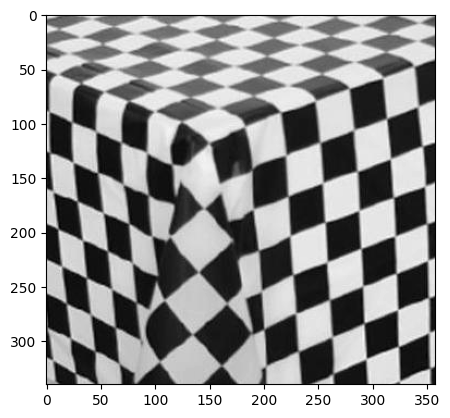

Cosine Similarity: 0.8946


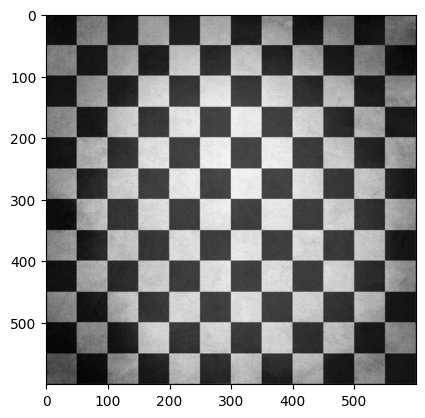

Cosine Similarity: 0.8909


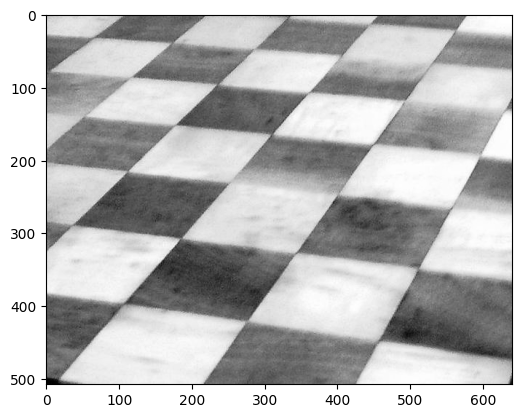

Cosine Similarity: 0.8840


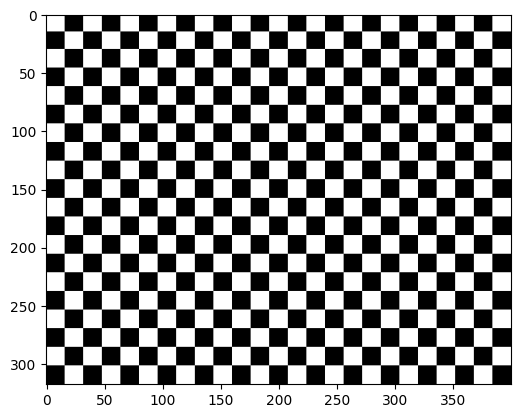

In [10]:
sample_sizes = [500, 1000, 1500]  # Number of images to use for clustering
k = 250  # Fixed number of centroids

for sample_size in sample_sizes:
    # Randomly sample descriptors
    sample_idx = np.random.randint(0, len(descriptors), sample_size).tolist()
    descriptors_sample = [descriptors[i] for i in sample_idx]
    all_descriptors = np.vstack(descriptors_sample)

    # Cluster descriptors using K-Means
    codebook, _ = kmeans(all_descriptors, k, 4)

    # Quantize descriptors to visual words
    visual_words = [vq(desc, codebook)[0] for desc in descriptors]

    # Compute TF-IDF
    frequency_vectors = np.array(
        [np.bincount(vw, minlength=k) for vw in visual_words])
    idf = np.log(len(frequency_vectors) /
                 np.sum(frequency_vectors > 0, axis=0))
    tfidf = frequency_vectors * idf

    # Compute cosine similarity for a query image
    search_i = 659  # Query image index
    a = tfidf[search_i]
    b = tfidf
    cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))

    # Get top-k similar images
    top_k = 5
    idx = np.argsort(-cosine_similarity)[:top_k]

    # Display results
    print(f"Results for sample size = {sample_size}")
    plt.imshow(bw_images[search_i], cmap='gray')
    plt.title("Query Image")
    plt.show()

    for i in idx:
        print(f"Cosine Similarity: {cosine_similarity[i]:.4f}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

# Vary the number of centroids (k)

Results for k = 100


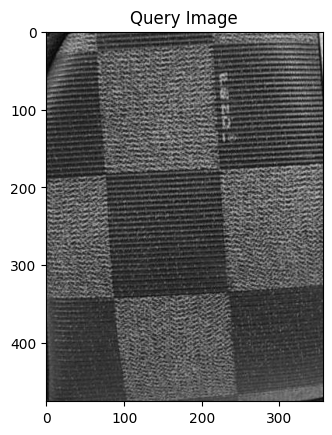

Cosine Similarity: 1.0000


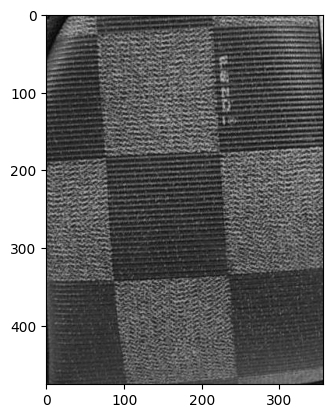

Cosine Similarity: 0.9094


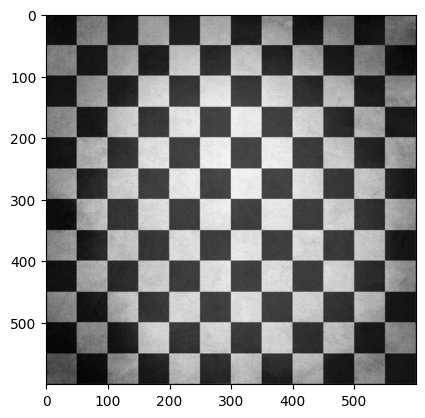

Cosine Similarity: 0.8858


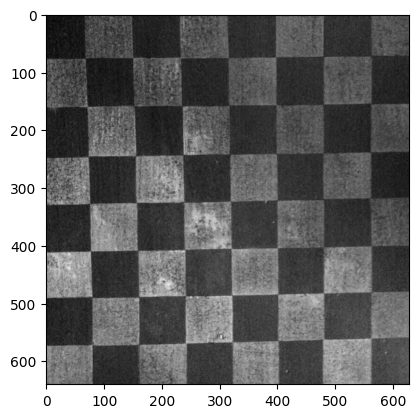

Cosine Similarity: 0.8732


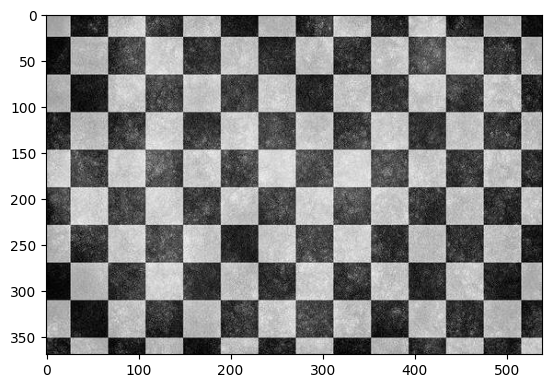

Cosine Similarity: 0.8718


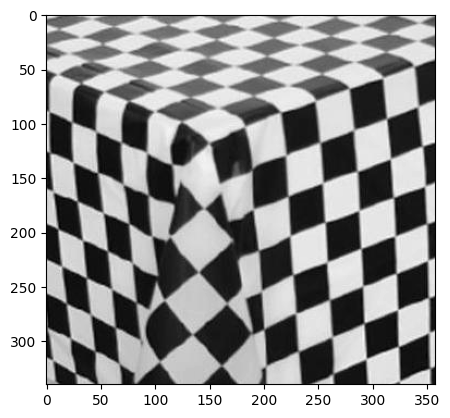

Results for k = 250


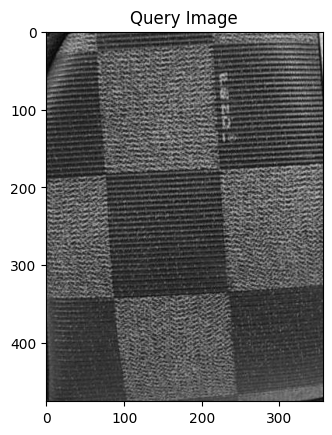

Cosine Similarity: 1.0000


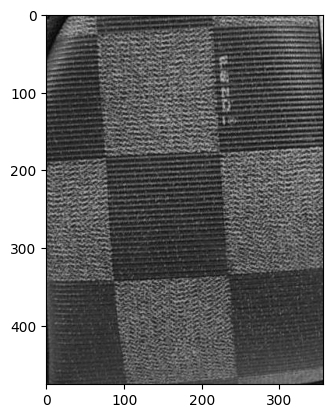

Cosine Similarity: 0.9090


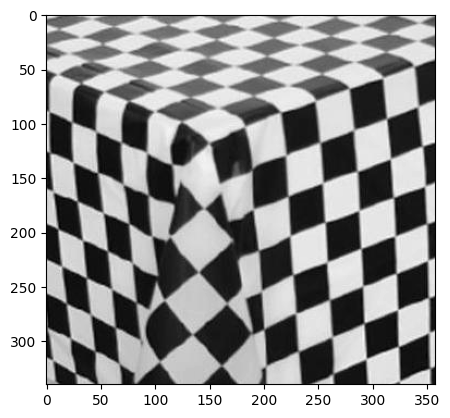

Cosine Similarity: 0.9015


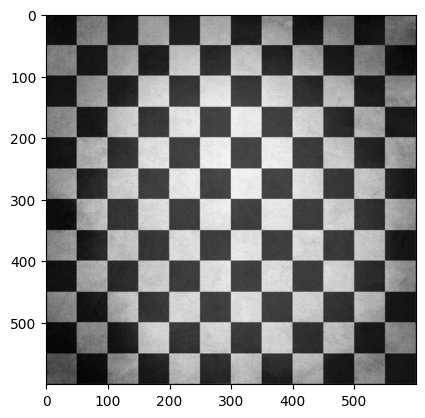

Cosine Similarity: 0.8926


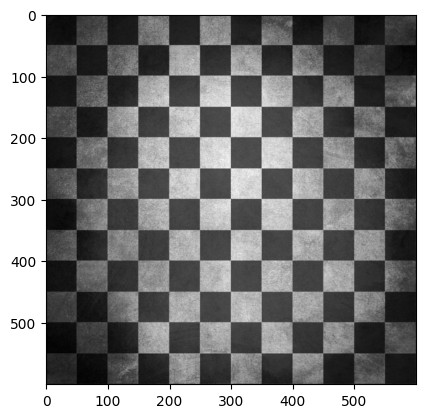

Cosine Similarity: 0.8915


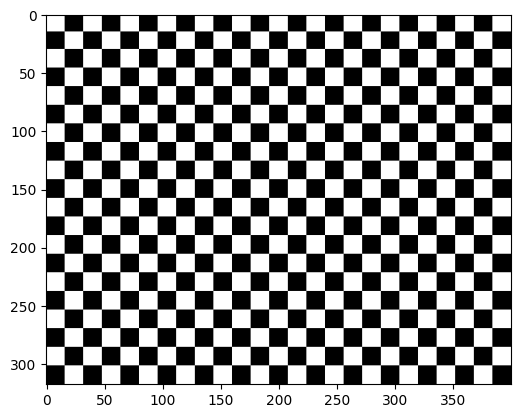

Results for k = 500


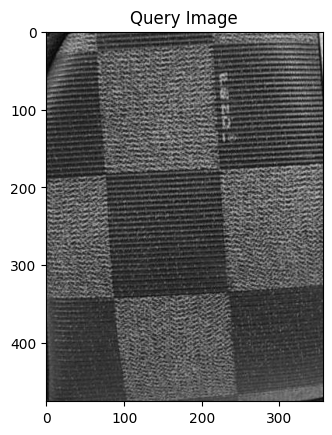

Cosine Similarity: 1.0000


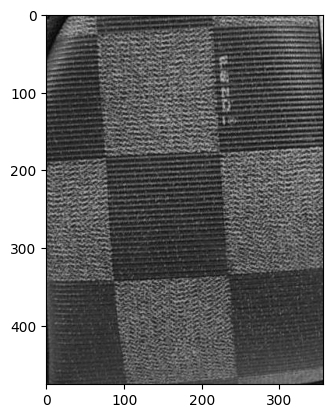

Cosine Similarity: 0.7339


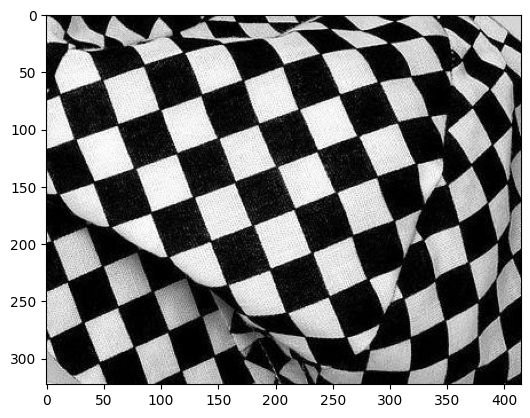

Cosine Similarity: 0.6863


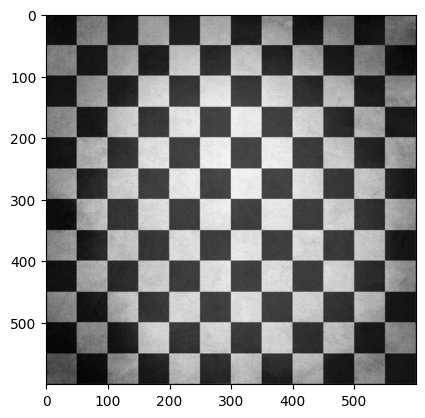

Cosine Similarity: 0.6790


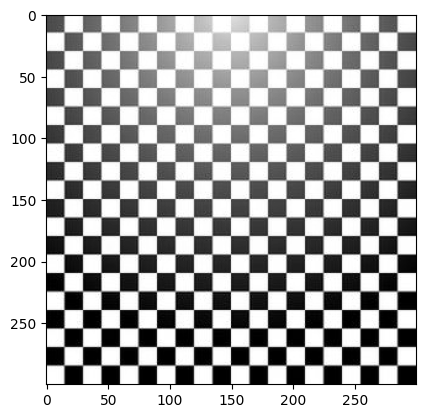

Cosine Similarity: 0.6718


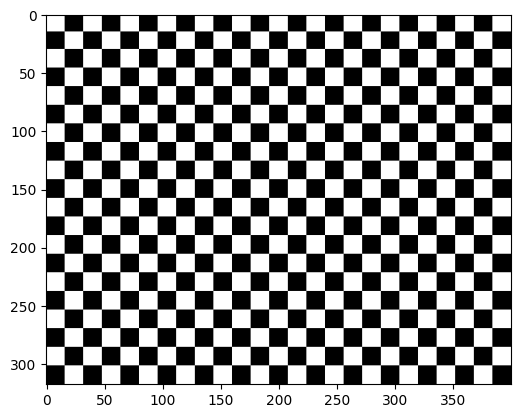

In [11]:
k_values = [100, 250, 500]  # Number of centroids
sample_size = 1000  # Fixed number of images for clustering

for k in k_values:
    # Randomly sample descriptors
    sample_idx = np.random.randint(0, len(descriptors), sample_size).tolist()
    descriptors_sample = [descriptors[i] for i in sample_idx]
    all_descriptors = np.vstack(descriptors_sample)

    # Cluster descriptors using K-Means
    codebook, _ = kmeans(all_descriptors, k, 4)

    # Quantize descriptors to visual words
    visual_words = [vq(desc, codebook)[0] for desc in descriptors]

    # Compute TF-IDF
    frequency_vectors = np.array(
        [np.bincount(vw, minlength=k) for vw in visual_words])
    idf = np.log(len(frequency_vectors) /
                 np.sum(frequency_vectors > 0, axis=0))
    tfidf = frequency_vectors * idf

    # Compute cosine similarity for a query image
    search_i = 659  # Query image index
    a = tfidf[search_i]
    b = tfidf
    cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))

    # Get top-k similar images
    top_k = 5
    idx = np.argsort(-cosine_similarity)[:top_k]

    # Display results
    print(f"Results for k = {k}")
    plt.imshow(bw_images[search_i], cmap='gray')
    plt.title("Query Image")
    plt.show()

    for i in idx:
        print(f"Cosine Similarity: {cosine_similarity[i]:.4f}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

# Compute BoW representation (without IDF normalization)

Results for Bag of Words (BoW):


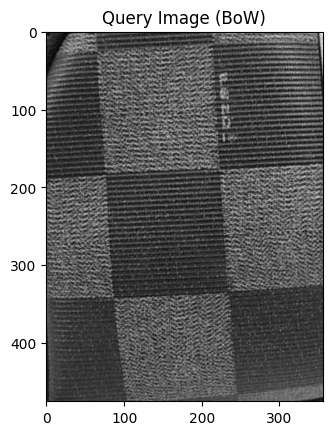

Cosine Similarity (BoW): 1.0000


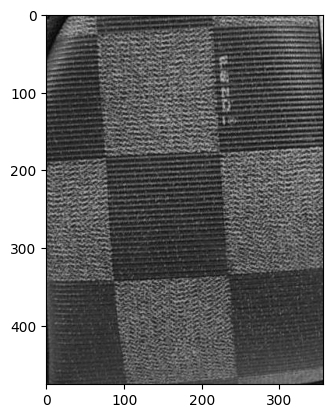

Cosine Similarity (BoW): 0.5054


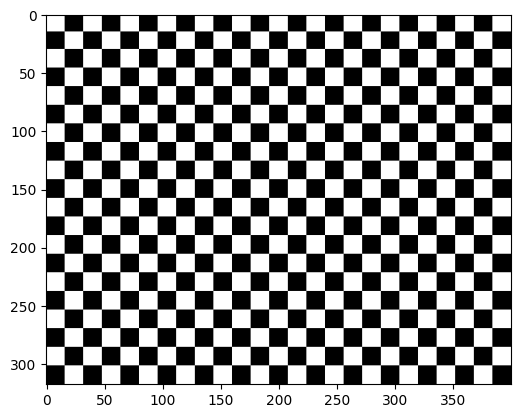

Cosine Similarity (BoW): 0.4900


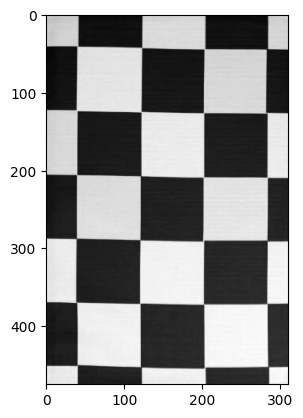

Cosine Similarity (BoW): 0.4875


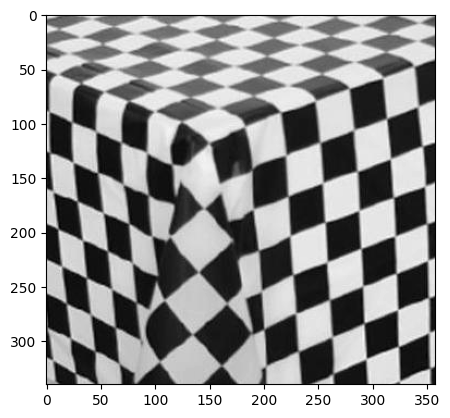

Cosine Similarity (BoW): 0.4820


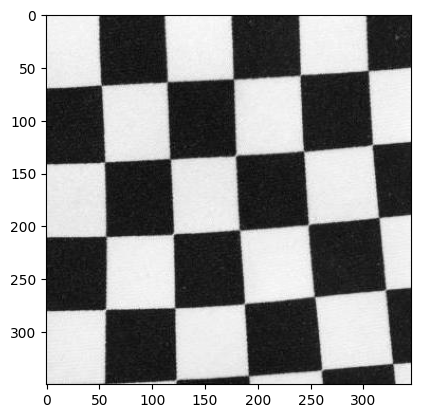

Results for TF-IDF:


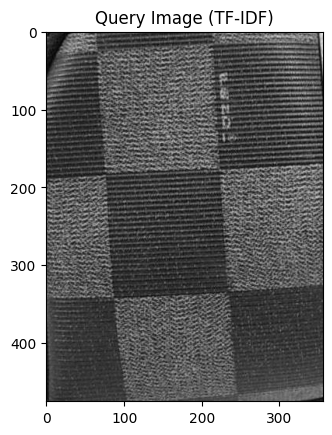

Cosine Similarity (TF-IDF): 1.0000


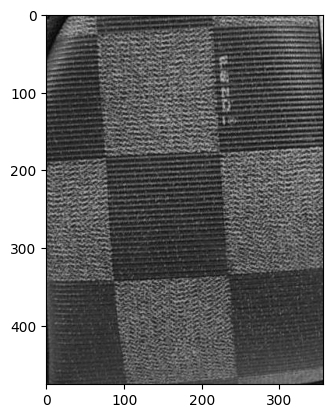

Cosine Similarity (TF-IDF): 0.7339


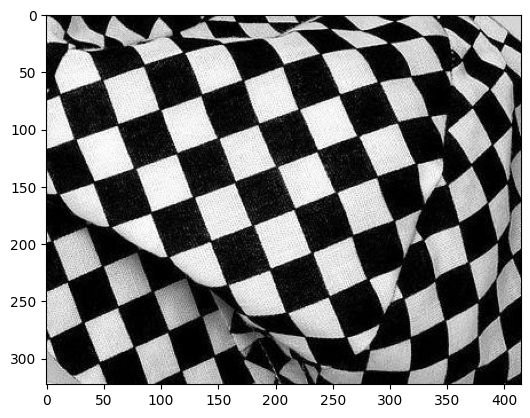

Cosine Similarity (TF-IDF): 0.6863


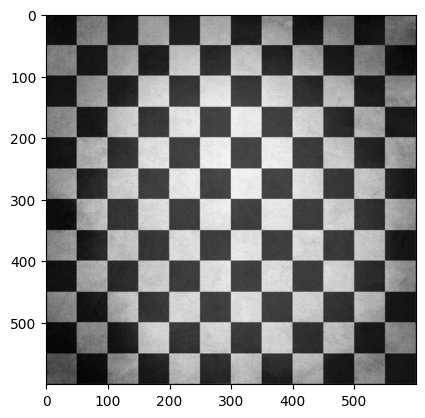

Cosine Similarity (TF-IDF): 0.6790


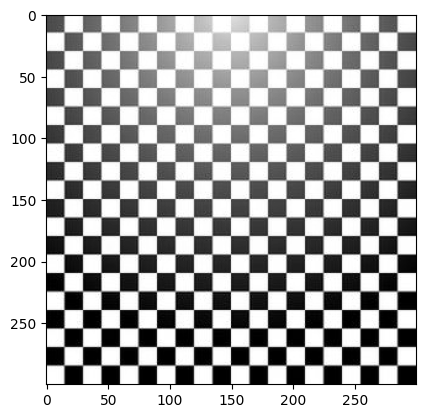

Cosine Similarity (TF-IDF): 0.6718


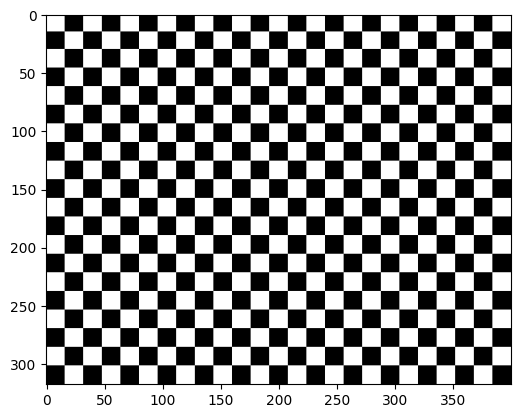

In [12]:
# Compute BoW representation (without IDF normalization)
bow_frequency_vectors = np.array(
    [np.bincount(vw, minlength=k) for vw in visual_words])

# Compute cosine similarity for BoW
bow_similarity = np.dot(bow_frequency_vectors[search_i], bow_frequency_vectors.T) / (
    norm(bow_frequency_vectors[search_i]) * norm(bow_frequency_vectors, axis=1))

# Get top-k similar images for BoW
bow_idx = np.argsort(-bow_similarity)[:top_k]

# Display results for BoW
print("Results for Bag of Words (BoW):")
plt.imshow(bw_images[search_i], cmap='gray')
plt.title("Query Image (BoW)")
plt.show()

for i in bow_idx:
    print(f"Cosine Similarity (BoW): {bow_similarity[i]:.4f}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()

# Compare with TF-IDF results
print("Results for TF-IDF:")
plt.imshow(bw_images[search_i], cmap='gray')
plt.title("Query Image (TF-IDF)")
plt.show()

for i in idx:
    print(f"Cosine Similarity (TF-IDF): {cosine_similarity[i]:.4f}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()